# Model Analysis
</p>In this notebook, we will analyze the performance of the models we have built. We will use the metrics `root_mean_squared_error`, `mean_absolute_error`, and `r2_score` to evaluate the performance of our models. We will also use the `bootstrap` and `kfold` functions to evaluate how well our models perform on unseen data.</p>

</p>For start, we will perform kfold cross-validation on the baseline models, which constitute of the 'ElasticNet', 'Bayesian Ridge' and 'Support Vector Regressor'. These will set the lower bound of our performance metrics.</p>

In [1]:
# Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib
import sys
import os
# I had an issue with importing functions from the src directory, so I used chatGPT to get the line below
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import functions

</p>Before defining the models we will load the csv files for development and evaluation. Except for the rows that were removed during cleaning, we will also remove the Host age row since we showed that it does not provide meaningful information for the model.</p>

In [2]:
input_path = Path.cwd()
root = input_path.parent
data_path = root / "data" / "development_final_data.csv"
train_df = pd.read_csv(data_path, header=0)
x = train_df.drop(columns=['BMI', 'Host age'])
y = train_df['BMI']
val_df = pd.read_csv(root / "data" / "evaluation_final_data.csv", header=0)
val_x = val_df.drop(columns=['BMI', 'Host age'])
val_y = val_df['BMI']

</p>Below we use kfold cross-validation to evaluate the performance of the baseline models. We will use the `mean_absolute_error`, `root_mean_squared_error`, and `r2_score` functions from `sklearn.metrics` to evaluate the performance of our models. The procedure is run 20 times with 5 folds each time and the results are used to create boxplots for each metric</p>

Model: ElasticNet


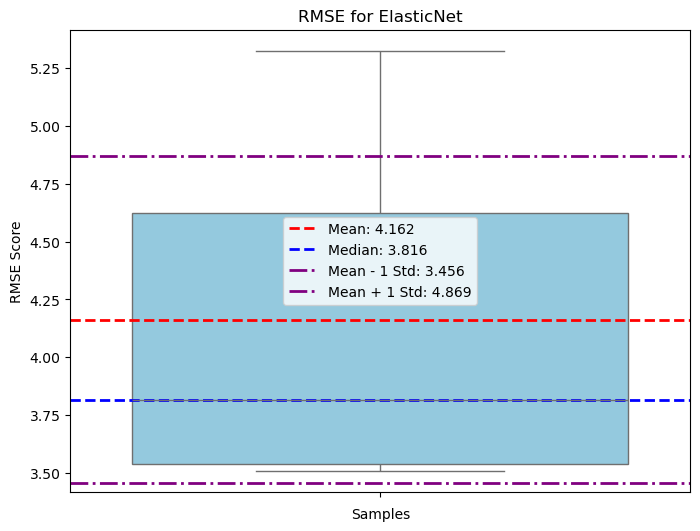

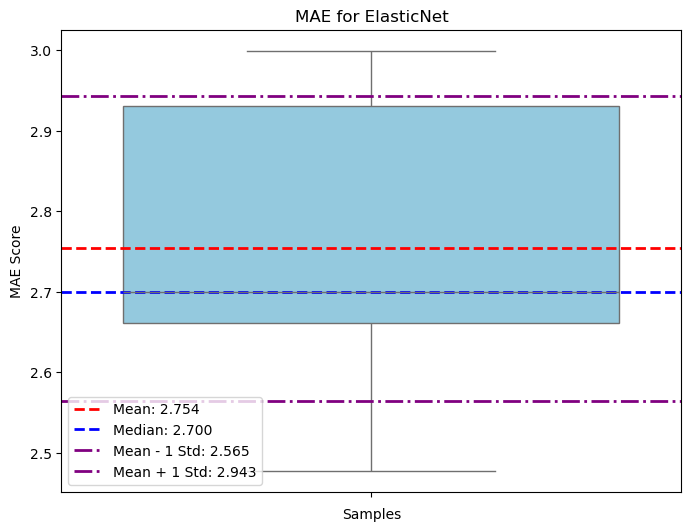

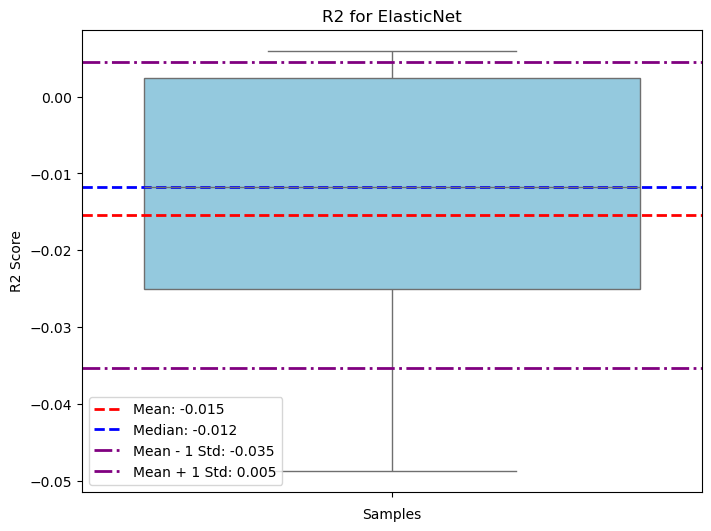

Model: BayesianRidge


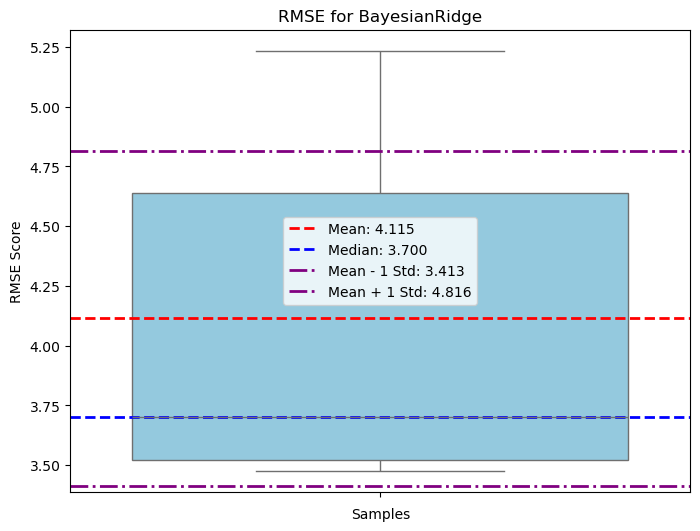

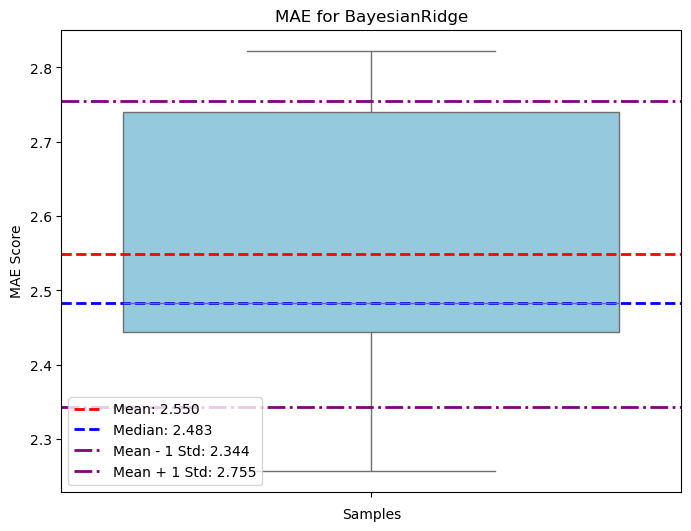

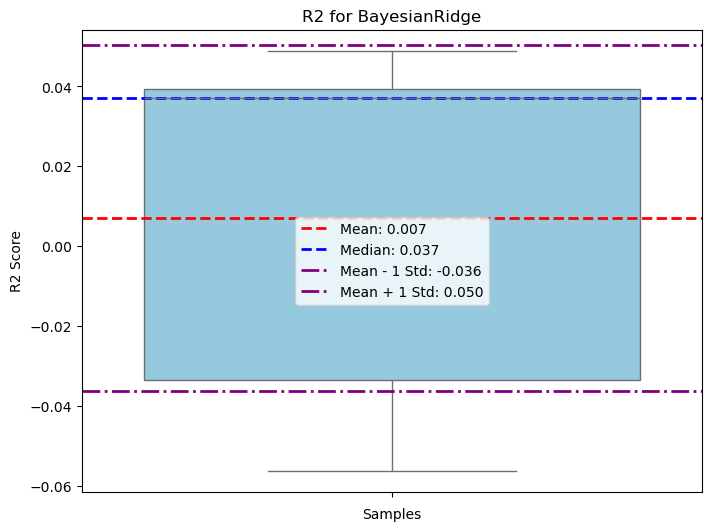

Model: SVR


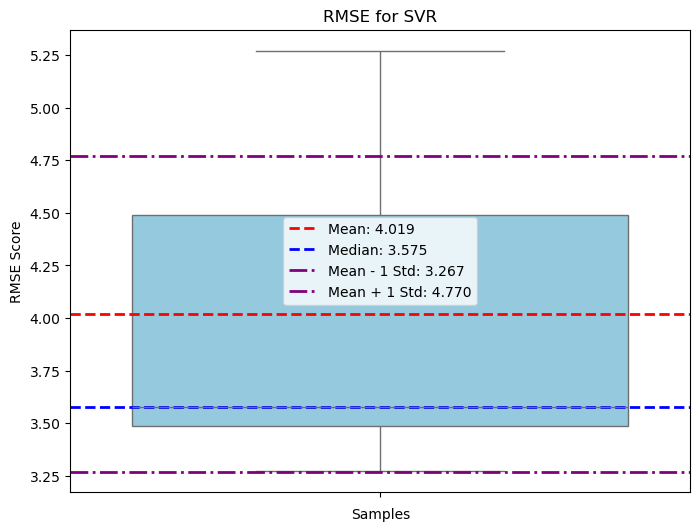

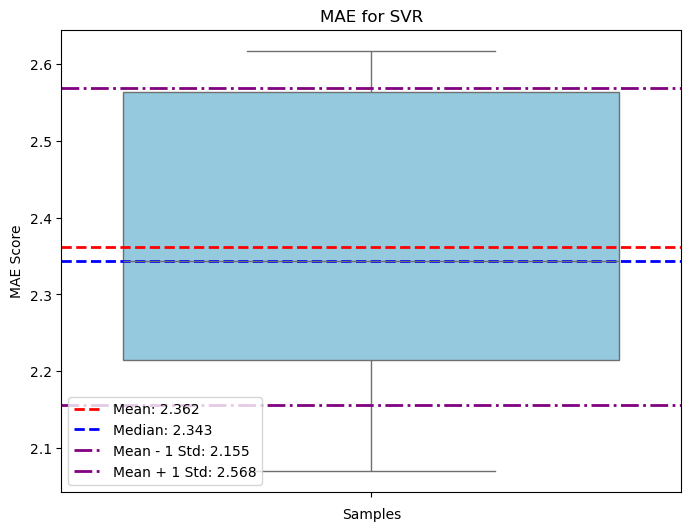

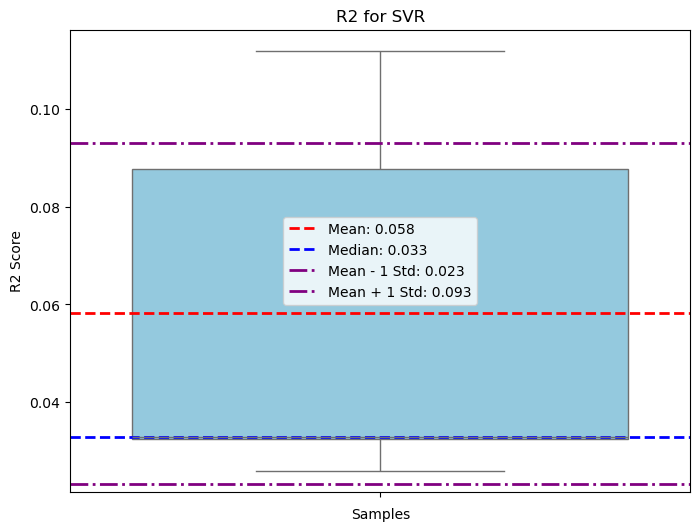

In [3]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, root_path=root, filename=f"{model.__class__.__name__}.pkl", save=True)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, trained_pipeline, n_iter=20, bstrap=False, kf=True)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2 = functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot(rmse_scores, model.__class__.__name__, "RMSE", mean_rmse, std_rmse, median_rmse)
    functions.create_boxplot(mae_scores, model.__class__.__name__, "MAE", mean_mae, std_mae, median_mae)
    functions.create_boxplot(r2_scores, model.__class__.__name__, "R2", mean_r2, std_r2, median_r2)

</p>Based on the results from k-fold cross-validation, we can see that the model that seems most promising is the SVR, since it has the lowest mean absolute error (MAE), the lowest root mean squared error (RMSE) and the highest R2 score. Regarding R2, the overall distributions also show the same picture as most of the values for the SVR are found in a range higher than the other models, while it is interesting that the R2 for the ElasticNet is mostly negative, which shows that it is likely to be the least reliable.</p>

Model: ElasticNet


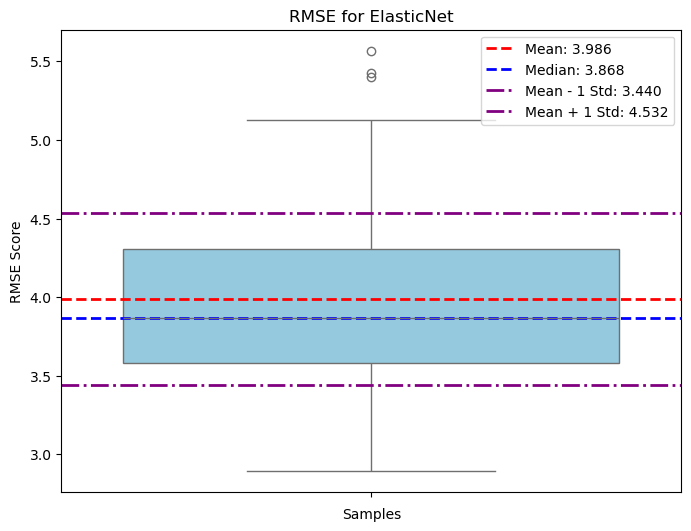

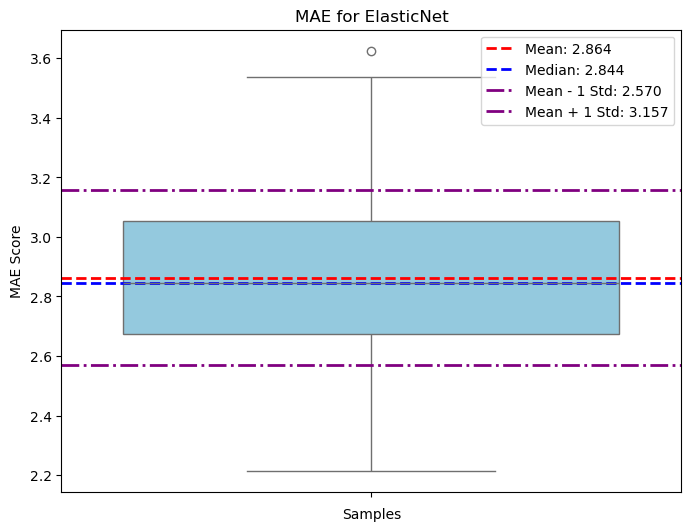

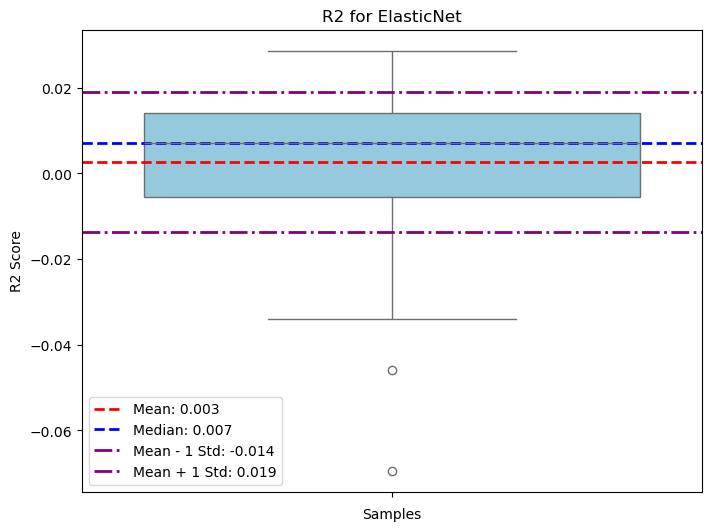

Model: BayesianRidge


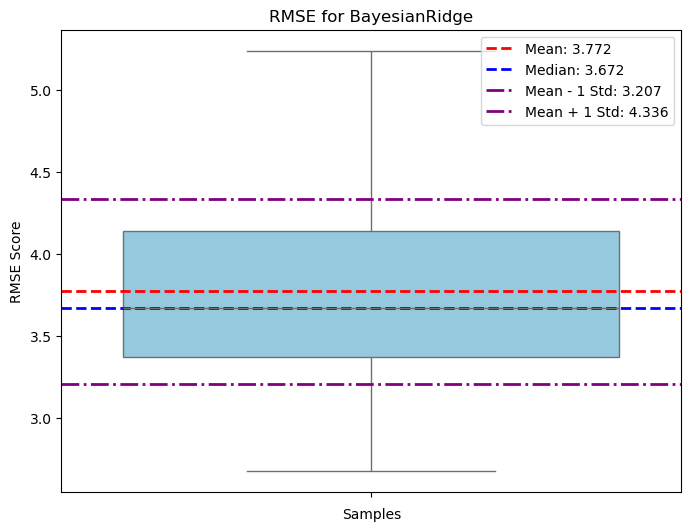

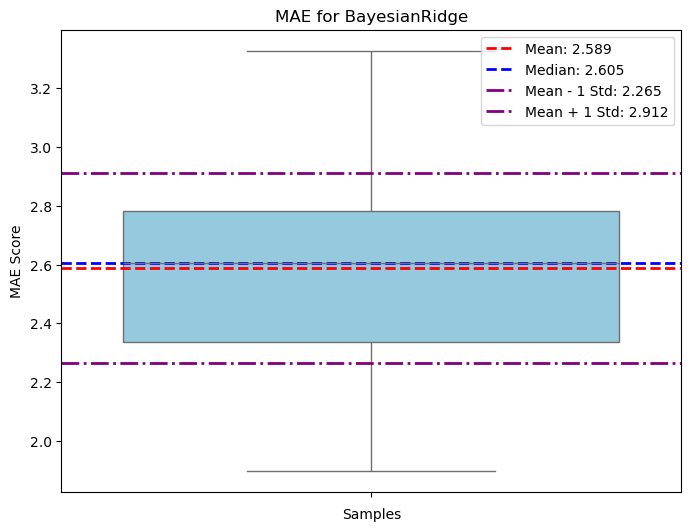

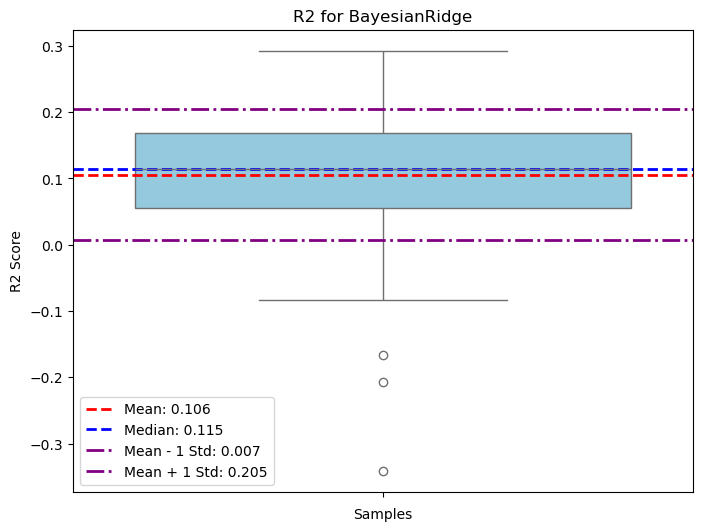

Model: SVR


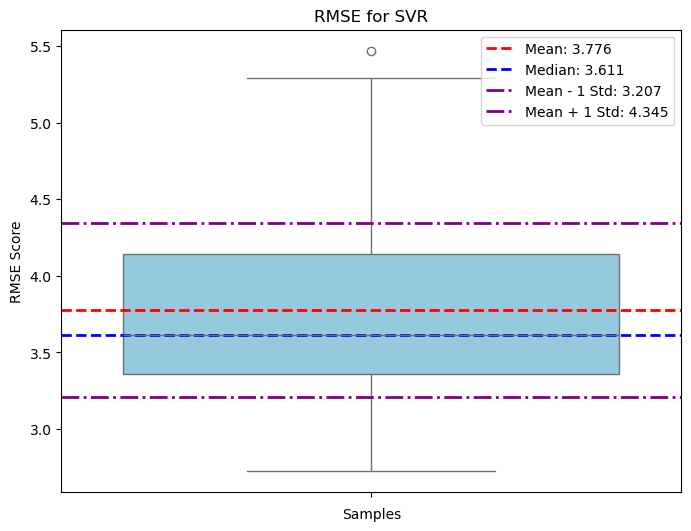

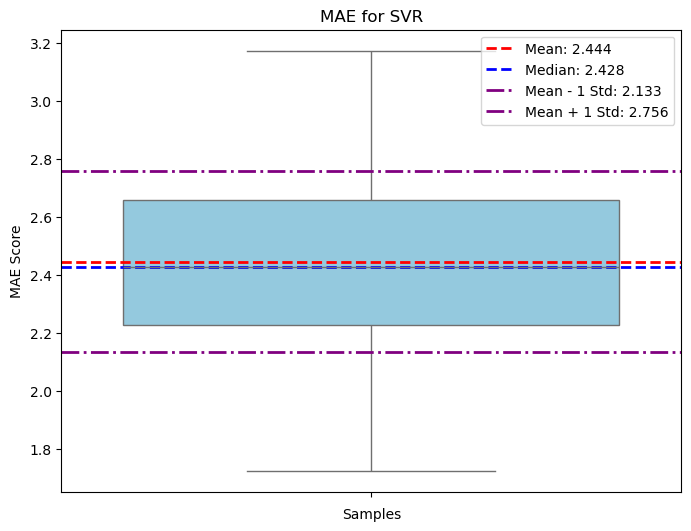

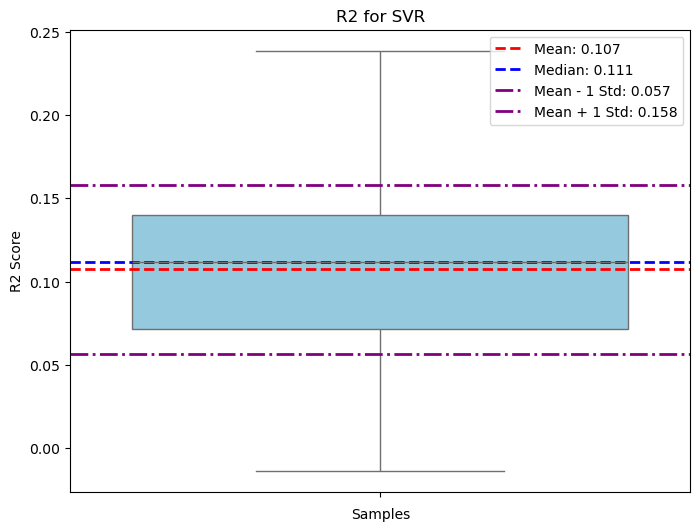

In [4]:
for model in [ElasticNet(), BayesianRidge(), SVR()]:
    print(f"Model: {model.__class__.__name__}")
    # Create a pipeline for each baseline model
    pipeline = functions.create_pipeline(model)
    preds, trained_pipeline = functions.train_model_and_predict(x, y, val_x, pipeline, filename=model.__class__.__name__)
    # Calculate metrics
    scores = functions.bootstrap(x, y, val_x, val_y, trained_pipeline, n_iter=100, bstrap=True, kf=False)
    rmse_scores, mae_scores, r2_scores = scores['rmse_scores'], scores['mae_scores'], scores['r2_scores']
    mean_rmse, std_rmse, median_rmse = functions.calculate_statistics(rmse_scores)
    mean_mae, std_mae, median_mae = functions.calculate_statistics(mae_scores)
    mean_r2, std_r2, median_r2= functions.calculate_statistics(r2_scores)
    # Create a boxplot
    functions.create_boxplot(rmse_scores, model.__class__.__name__, "RMSE", mean_rmse, std_rmse, median_rmse)
    functions.create_boxplot(mae_scores, model.__class__.__name__, "MAE", mean_mae, std_mae, median_mae)
    functions.create_boxplot(r2_scores, model.__class__.__name__, "R2", mean_r2, std_r2, median_r2)

In [5]:
models = [ElasticNet(), BayesianRidge(), SVR()]
rfe = RFE(estimator=ElasticNet(), n_features_to_select=5)
for model in models:
    print(model.__class__.__name__)
    functions.grid_search(model, x, y, cv=5, scoring='neg_mean_squared_error', rfe_selector=rfe)

ElasticNet
{'feature_selector__n_features_to_select': 50}
-17.823792319665863
BayesianRidge
{'feature_selector__n_features_to_select': 50}
-17.66375631345725
SVR
{'feature_selector__n_features_to_select': 50}
-16.807708929706642
